# Girish Fan Club's Shoe Recommender
#### By Sialoi Ta'a, Joshua Lapidario, Mabel Szeto, Jay Buensuceso
This is our COGS 118B Winter Quarter Final Project!!!  
In this notebook, we display data preprocessing similar to pipelining, hierarchical clustering, visualization of clustering, a shoe recommendation system based off of the clustering algorithm used and a silhouette score at the end to evaluate the quality of the model.  
  
**There are 10 sections:**  
1.                Libary Includes           
2.             Function Definitions         
3.                  Data Loader             
4.                Preprocessing             
5.            Clustering Initialization     
6.              Cluster Visualization       
7.            Peeking Inside A Cluster      
8.                  Test Input              
9.               Evaluation Metric          
10.              Best Model Parameters       

# Libary Includes
These are all of the libraries we decided to use in our project notebook.

In [15]:
# things we will need to do stuff in this notebook
%pip install umap-learn
import numpy as np
import pandas as pd
from scipy import stats
from numpy.linalg import norm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE
from IPython.display import display
from PIL import Image
import numpy as np
import os
from sklearn.metrics.pairwise import euclidean_distances
import random
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import dendrogram

# two useful data viz libraries
import matplotlib.pyplot as plt

# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

Note: you may need to restart the kernel to use updated packages.


# Function Definitions
This section is devoted to holding all of the necessary functions we made for our project to run smoothly. The purpose of each function will be found in the comment above the definition.

In [16]:
# Find Centroids
def find_centroids(labels, num_of_clusters, data):
    cluster_means = np.zeros((num_of_clusters, 2))
    for i in range(num_of_clusters):  # Start from 0 and iterate up to num_of_clusters - 1
        # Finds the points associated with cluster i
        indices = labels == i
        cluster_means[i] = np.sum(data[indices, :], axis=0) / np.sum(indices)
    return cluster_means

# Visualize clusters with centroids
def visualize_clusters(umap_embeddings, cluster_labels, centroids):
 
    num_clusters = len(np.unique(cluster_labels))
    
    colors = plt.cm.get_cmap('tab20', num_clusters)
    
    # Create a scatter plot of the UMAP embeddings with each cluster colored differently
    plt.figure(figsize=(8, 6))
    for i, cluster_label in enumerate(np.unique(cluster_labels)):
        plt.scatter(umap_embeddings[cluster_labels == cluster_label, 0], 
                    umap_embeddings[cluster_labels == cluster_label, 1], 
                    label=f'Cluster {cluster_label}', color=colors(i))
    for i in range(num_clusters):
        plt.scatter(centroids[i, 0], centroids[i, 1], color='black', marker='x', s=100)
        plt.text(centroids[i, 0], centroids[i, 1], f'Centroid {i}', fontsize=10, verticalalignment='bottom')

    plt.title('Clusters Visualization')
    plt.xlabel('Combined UMAP/T-SNE Dimension 1')
    plt.ylabel('Combined UMAP/T-SNE Dimension 2')
    ncolsint = 4
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols=ncolsint)
    plt.show()

# Visualizae the shoes inside a user desired cluster
def visualize_shoes(input_label, cluster_labels, color_image_collection):
    cluster_indices = np.where(cluster_labels == input_label)[0]
    # Randomly select three indices from the cluster (excluding the input image)
    random_indices = random.sample(list(cluster_indices), min(9, len(cluster_indices)))

    # Create a grid of subplots
    fig, axes = plt.subplots(3, 3)

    # Plot images on the subplots using the indices from random_indices list
    for i, index in enumerate(random_indices):
        ax = axes.flat[i]
        ax.imshow(color_image_collection[index].reshape((102, 136, 3)).astype(int), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Shoe {i+1}')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Gets user inputted image, puts it inside the notebook, and shapes it for further preprocessing
def input_image_preprocesser(pathway):
    # Loads the images into the notebook as a list and then changes it to a numpy array
    image_list = Image.open(pathway)
    #display(image_list)
    color_input_shoe = np.array(image_list)
    # Convert to grayscale
    image_gray = image_list.convert('L')    
    image_np = np.array(image_gray)
    
    # Flatten the image
    image_flat = image_np.reshape(1, -1) 
    return color_input_shoe, image_flat

# Plots the silhouette score of the clustering using the predicted labels and the dimension reducted dataset
def plot_silhouette_score(umap_embedding, labels):
    silhouette_scores = silhouette_samples(umap_embedding, labels)
    silhouette_avg = silhouette_score(umap_embedding, labels)
    
    # Create a subplot with 1 row and 1 column
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 15)
    y_lower = 10
    
    for i in range(len(set(labels))):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = silhouette_scores[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / len(set(labels)))
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([]) 
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

# Shows the input shoe and the 3 recommendations from the clustering
def display_image_subset(images):
    titles = ["Input Shoe", "Rec Shoe 1", "Rec Shoe 2", "Rec Shoe 3"]
    fig, axes = plt.subplots(nrows=1, ncols=4)
    #plt.subplots_adjust(wspace=5)
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(titles[i], fontsize=10)
        ax.axis('off')  # Turn off axis
    #plt.tight_layout(pad=100)
    plt.show()



# Data Loader
In this section we're loading in the dataset into the notebook. The files are taken from the sneakers folder in this directory. IT'S IMPORTANT TO KNOW THAT THIS NOTEBOOK WILL NOT WORK WITHOUT THE SNEAKERS FOLDER!!!

In [17]:
# Default parameters of the images
default_width = 136
default_length = 102
default_dimension = default_width * default_length # this change is for the grayscale to work 
num_of_channels = 3
default_color_dimension = default_width * default_length * num_of_channels

#default_dimension = 35625

# Load in all of the images stored in the sneakers folder
# Define the collection of images
image_collection = np.zeros((1, default_dimension))
color_image_collection = np.zeros((1, default_color_dimension))
print(f"image_collection shape is: {image_collection.shape}")
# Pathway to the main folder that holds all types of shoes
main_path = "./sneakers"
# Makes a list of folder names found in the main folder
folders = os.listdir(main_path)
# Iterates through those folder names
for i, folder in enumerate(folders):
    # Keeps track of progress of folder dive
    print(f"Inside folder {i+1}: {folder}")
    # Creates the pathway to the folder inside the main folder 
    folder_path = os.path.join(main_path, folder)
    # List all files in the folder
    files = os.listdir(folder_path)
    # Iterate through all of the files and add them to the collection of flattened images
    for file in files:
        # Creates the pathway to the images inside the folder
        image_path = os.path.join(folder_path, file)
        # Loads the images into the notebook as a list and then changes it to a numpy array
        image_list = Image.open(image_path)
        image_color_np = np.array(image_list)
        image_gray = image_list.convert('L')  # Convert to grayscale
        image_np = np.array(image_gray)
        
        # Flatten the image
        image_flat = image_np.reshape(1, -1)
        color_image_flat = image_color_np.reshape(1, -1)
        # If this is the first image, index instead of stack inside the collection
        if i == 0:
            image_collection[0] = image_flat
            color_image_collection[0] = color_image_flat
        else:
            image_collection = np.vstack((image_collection, image_flat))
            color_image_collection = np.vstack((color_image_collection, color_image_flat))
# for loop ends here
print(f"image_collection shape is: {image_collection.shape}")
print(f"color_image_collection shape is: {color_image_collection.shape}")

image_collection shape is: (1, 13872)
Inside folder 1: Reebok
Inside folder 2: Paul Smith
Inside folder 3: DVS Shoe Company
Inside folder 4: DSQUARED2
Inside folder 5: Amiana
Inside folder 6: Aetrex
Inside folder 7: ALDO
Inside folder 8: Lacoste
Inside folder 9: AlexanderMcQueen
Inside folder 10: AdidasOriginals
Inside folder 11: GUESS
Inside folder 12: Easy Spirit
Inside folder 13: Crocs
Inside folder 14: UGG
Inside folder 15: adidasY-3
Inside folder 16: BetseyJohnson
Inside folder 17: Nike
Inside folder 18: SKECHERS
Inside folder 19: ECCO
Inside folder 20: Converse
Inside folder 21: KangaROOS
image_collection shape is: (1988, 13872)
color_image_collection shape is: (1988, 41616)


# Preprocessing
In this section we're preprocessing the dataset before it goes into the clustering algorithm. The method of preprocessing is a pipeline that uses UMAP to TSNE.

In [18]:
# Preprocess the data
# Because of the curse of dimensionality, we'll use UMAP to reduce the dimensionality
image_collection_mean = np.mean(image_collection, axis=0, keepdims=True)

# Mean centered data
mean_centered_data = image_collection - image_collection_mean

n_components = 2
# Best UMAP Params: 10 neighbors, 100 components, 0.05 min_dist
umap_v1 = UMAP(n_neighbors=10, n_components=n_components*50, random_state=99, min_dist=0.05) #lowered the n_neighbors from 40 and the min_dist from 0.07
# Best TSNE Params: 2 components, 15 perplexity
tsne_v1 = TSNE(n_components=n_components,perplexity=15,random_state=99)
reduced_image_collection = umap_v1.fit_transform(mean_centered_data)
reduced_image_collection = tsne_v1.fit_transform(reduced_image_collection)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


# Clustering Initialization
In this section we initialize our clustering object for fitting, transforming and predicting. The clustering algorithm we're using is a hierarchical clustering method.

In [19]:
num_clusters = 72 # Best number of clusters: 72
clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')  
cluster_labels = clustering.fit_predict(reduced_image_collection)

In [20]:
max_number_of_clusters = max(cluster_labels)+1  # Get the maximum cluster label
cluster_to_samples = {}

for elem in cluster_labels:
    if elem in cluster_to_samples:
        cluster_to_samples[elem] += 1
    else:
        cluster_to_samples[elem] = 1

print(f"The max number of clusters found were: {max_number_of_clusters}")
print(cluster_to_samples)

The max number of clusters found were: 72
{23: 27, 62: 18, 9: 27, 3: 33, 18: 38, 20: 28, 44: 21, 15: 44, 47: 30, 65: 15, 54: 21, 6: 63, 53: 17, 17: 21, 7: 46, 50: 30, 51: 24, 1: 41, 33: 33, 30: 27, 38: 26, 42: 24, 59: 21, 31: 23, 27: 44, 70: 23, 63: 23, 0: 42, 22: 27, 12: 25, 46: 32, 66: 12, 29: 22, 37: 21, 58: 37, 60: 20, 39: 22, 43: 25, 71: 17, 32: 18, 13: 40, 57: 18, 34: 33, 2: 53, 61: 27, 14: 36, 28: 40, 40: 22, 52: 18, 21: 31, 49: 24, 67: 17, 19: 23, 45: 32, 10: 41, 35: 26, 68: 16, 56: 20, 36: 31, 16: 36, 5: 23, 64: 17, 41: 38, 55: 21, 11: 20, 24: 22, 4: 34, 48: 17, 26: 22, 8: 34, 25: 27, 69: 21}


# Cluster Visualization
In this section we'll be able to visually see our clustering and the names of the clusters.

/var/folders/y3/8fq070r15zvgth8g2j9l9kfr0000gn/T/ipykernel_58010/2516211362.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_clusters)


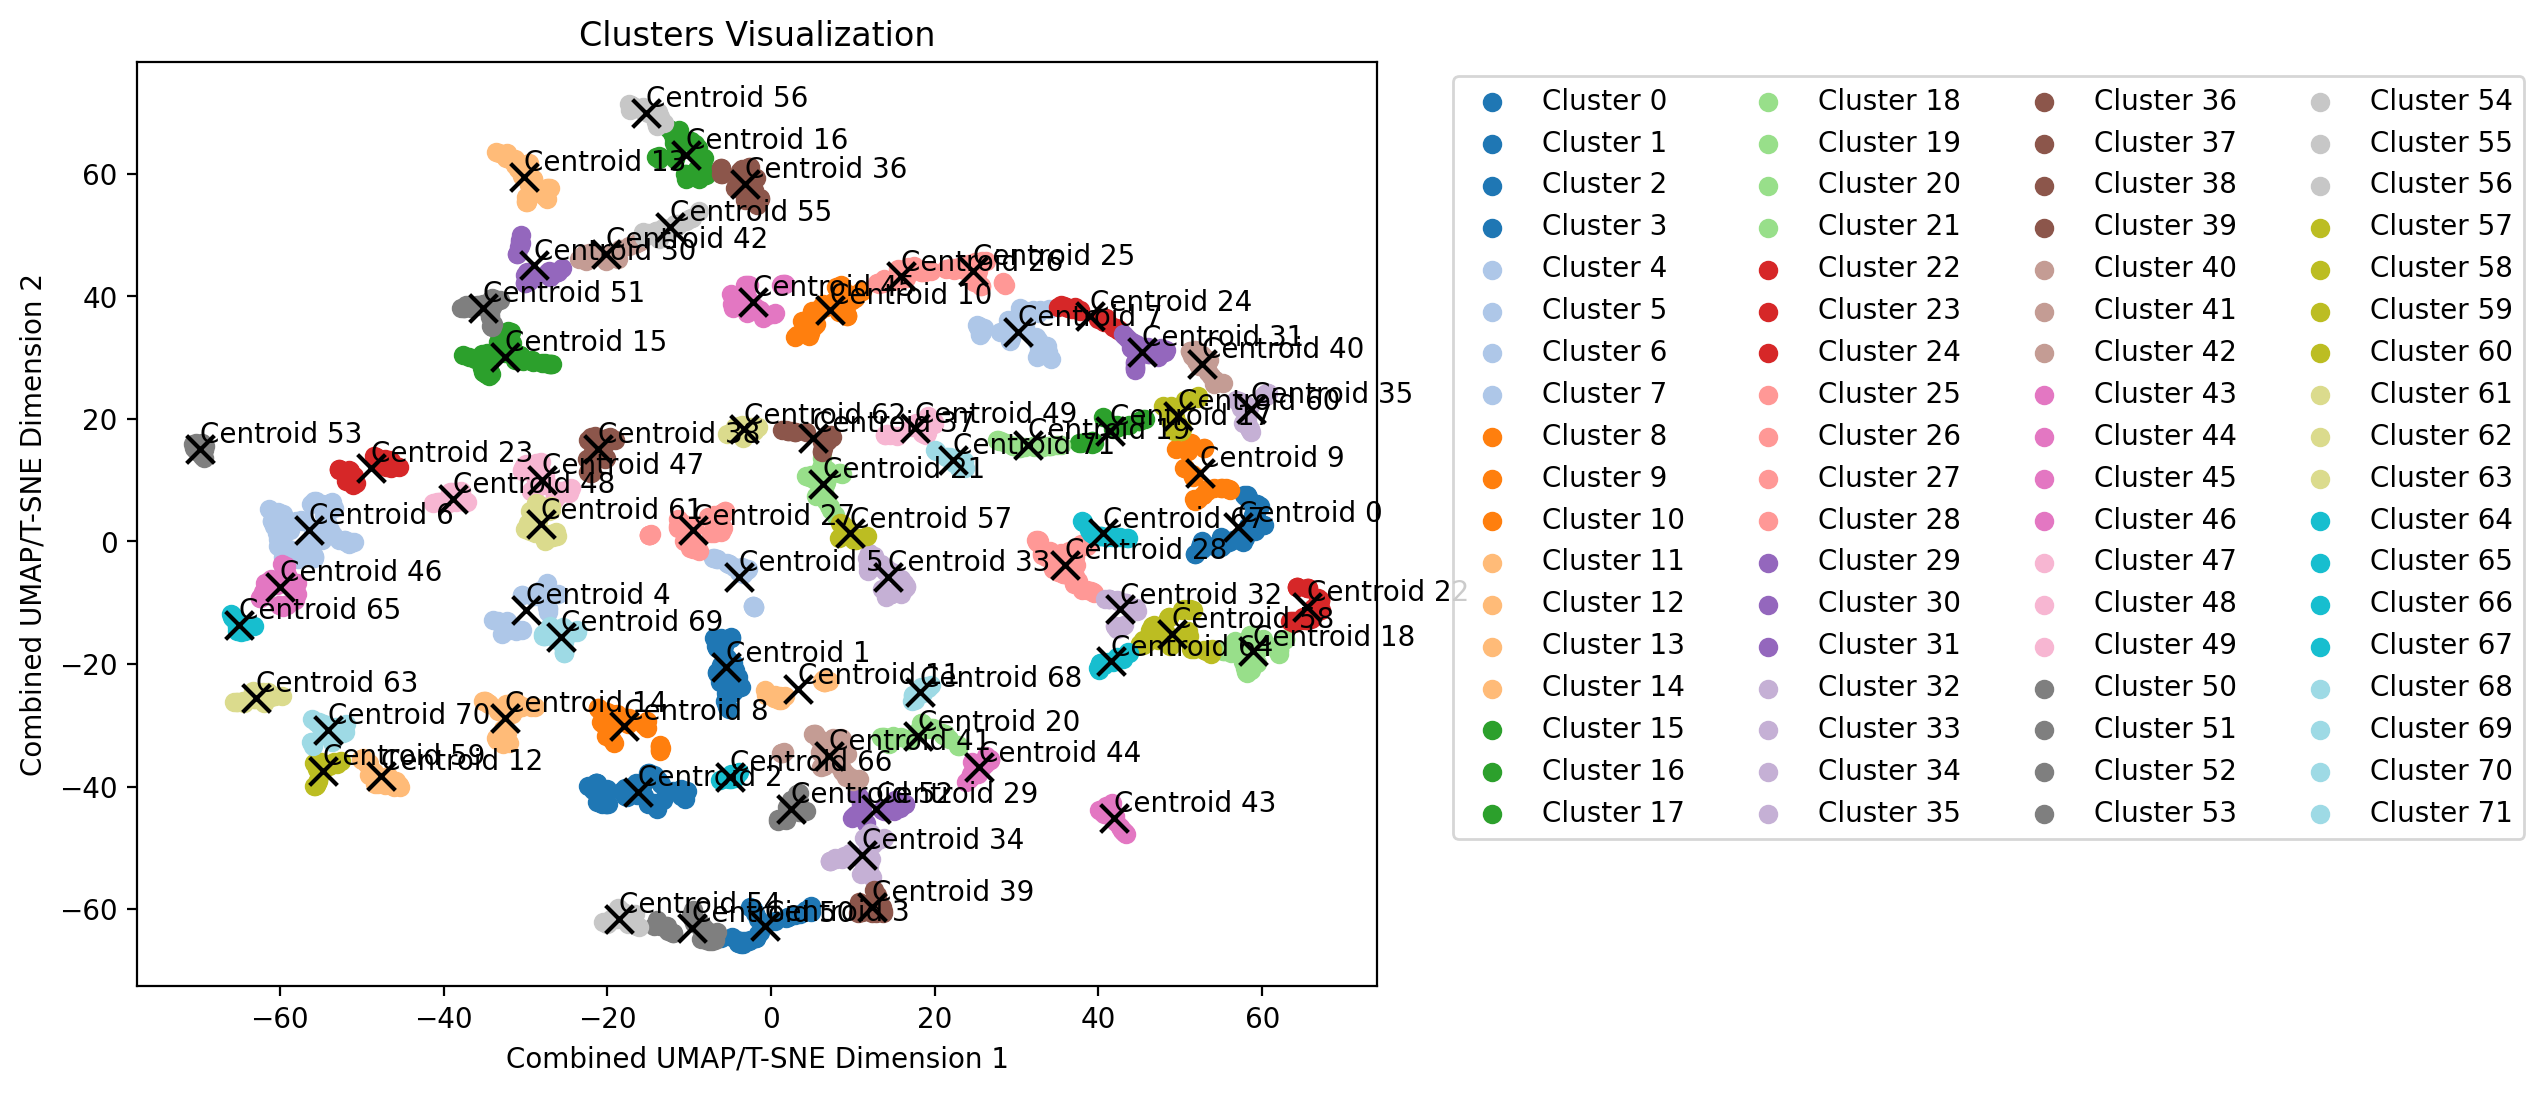

In [21]:
centroids = find_centroids(cluster_labels, max_number_of_clusters, reduced_image_collection)
visualize_clusters(reduced_image_collection, cluster_labels,centroids)

## Peeking Inside A Cluster
This next cell allows up to choose which cluster label we want to look inside. By changing the first parameter in the visualize_shoes function, we can look at 9 random images inside the cluster.

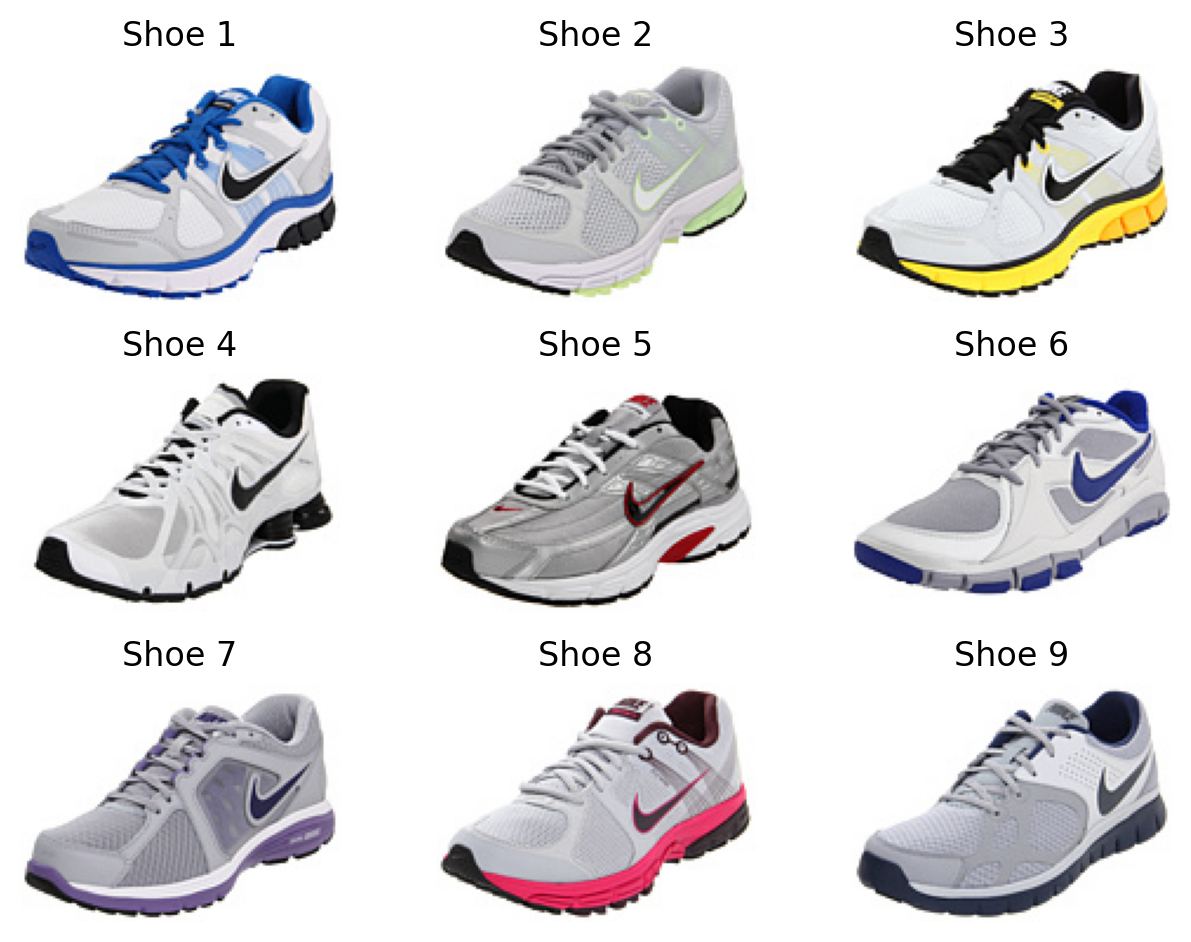

In [22]:
# Put in any cluster label and the clustered lables to be able to see what's inside that cluster
visualize_shoes(25, cluster_labels, color_image_collection)

## Test Input
By changing the file pathway inside the input_image_preprocesser function to any shoe in the ZAPOS dataset, we can see what cluster the input shoe was placed inside of and what shoes we recommend based on our findings.

In [29]:
# Assuming 'input_image_path' is the path to the input image

color_input_shoe, input_image = input_image_preprocesser("test/7954646.3.jpg")
centered_input = input_image - image_collection_mean
umap_embedding_input = np.expand_dims(centered_input, axis=0)
umap_embedding_input = umap_embedding_input[0]
umap_embeddings_combined = np.concatenate((mean_centered_data, umap_embedding_input), axis=0)

umap_embeddings_combined = umap_v1.fit_transform(umap_embeddings_combined)
umap_embeddings_combined = tsne_v1.fit_transform(umap_embeddings_combined)

#umap_embeddings_combined = np.concatenate((reduced_image_collection, input_image), axis=0)
cluster_labels = clustering.fit_predict(umap_embeddings_combined)
predicted_cluster_label = cluster_labels[-1]
print("Predicted Cluster Label:", predicted_cluster_label)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Predicted Cluster Label: 6


43


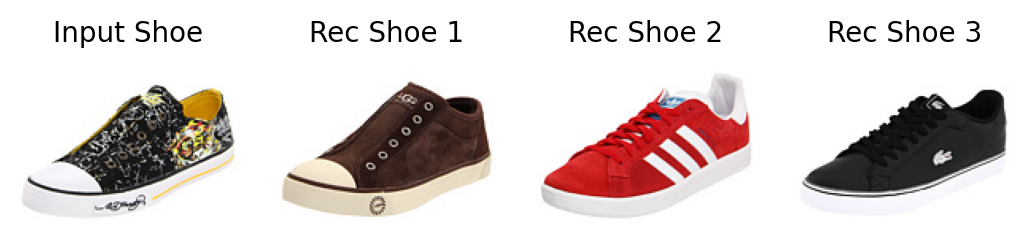

Selected Images from the Cluster: [552, 315, 166]


In [30]:
cluster_indices = np.where(cluster_labels == predicted_cluster_label)[0]
print((len(cluster_indices)))
# Randomly select three indices from the cluster (excluding the input image)
random_indices = 0
while True:
    random_indices = random.sample(list(cluster_indices), min(3, len(cluster_indices)))
    if color_image_collection.shape[0] not in random_indices:
        break


images_to_display = [color_image_collection[i].reshape((102, 136, 3)).astype(int) for i in random_indices]
input_to_display = np.expand_dims(color_input_shoe, axis=0)
images_to_display = np.concatenate((input_to_display, images_to_display), axis=0)

display_image_subset(images_to_display)
print("Selected Images from the Cluster:", random_indices)

# Evaluation Metric
We'll be using a silhouette scoring method to evaluate how well our clustering has done. Please use this to see how well your parameters do.

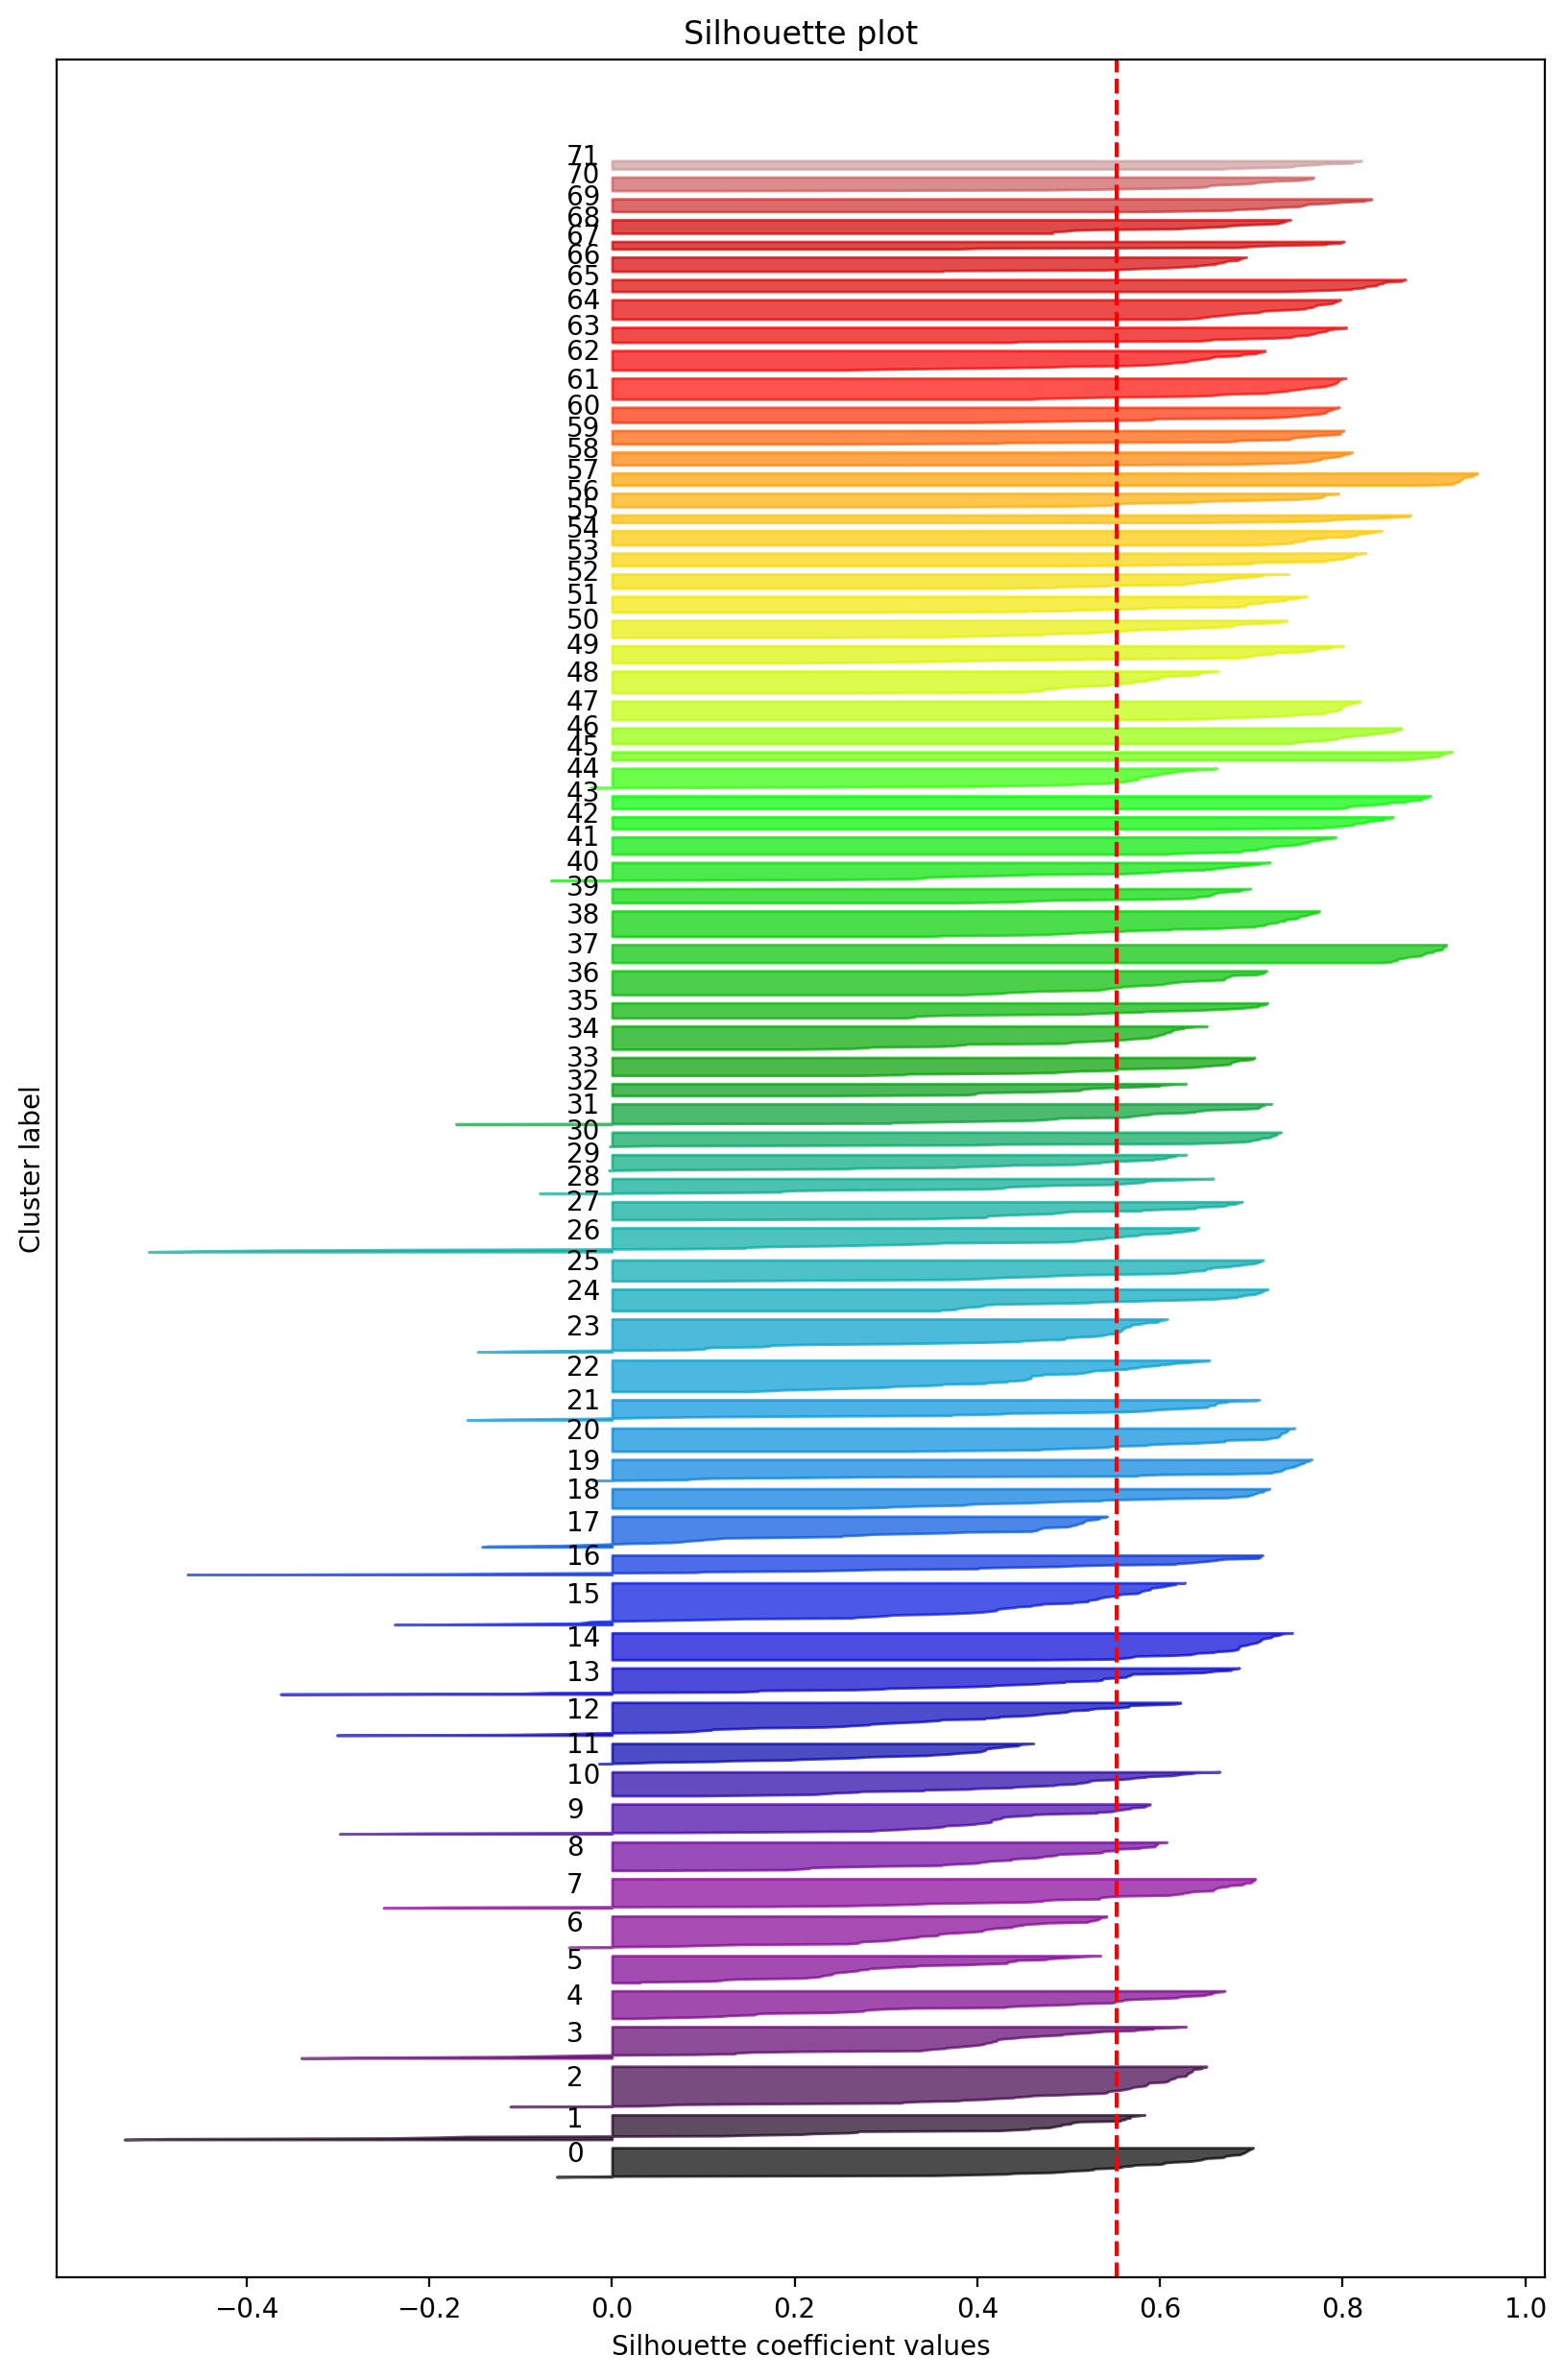

Silhouette Score: 0.55273473


In [25]:
plot_silhouette_score(umap_embeddings_combined, cluster_labels)

silhouette_avg = silhouette_score(umap_embeddings_combined, cluster_labels)
print("Silhouette Score:", silhouette_avg)

# Best Model Parameters

In [26]:
"""
Best Model Parameters Up To Date

Best Silhouette Score: 0.59216785

UMAP Params {
    n_neighbors: 10
    n_components: 100
    random_state: 99
    min_dist: 0.05
}

TSNE Params {
    n_components: 2
    perplexity: 15
    random_state: 99
}

Number of Clusters: 72
"""

'\nBest Model Parameters Up To Date\n\nBest Silhouette Score: 0.59216785\n\nUMAP Params {\n    n_neighbors: 10\n    n_components: 100\n    random_state: 99\n    min_dist: 0.05\n}\n\nTSNE Params {\n    n_components: 2\n    perplexity: 15\n    random_state: 99\n}\n\nNumber of Clusters: 72\n'